In [168]:
from scipy.io import wavfile
from numpy.fft import fft
from matplotlib.pyplot import bar
from matplotlib import pyplot
from pympler.asizeof import asizeof
from os import listdir
from os.path import isdir, join
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from python_speech_features import mfcc, logfbank
from sklearn.metrics import confusion_matrix

In [2]:
base_path = '/Users/ivannikolaev/projects/data/trams/dataset/'

In [3]:
fs, data = wavfile.read('/Users/ivannikolaev/projects/data/trams/dataset/accelerating/2_CKD_Long/tram-2018-11-21-20-57-21_79.33_83.17.mp4.wav')

In [79]:
data_fs = 22050

In [169]:
logfbank(data, data_fs)

array([[29.38449134, 29.68244027, 29.76083357, ..., 31.59290335,
        31.51570543, 31.7984251 ],
       [30.26927417, 30.84591516, 30.66650567, ..., 29.69533468,
        29.32008327, 29.26209079],
       [30.02065042, 30.63949393, 30.5042193 , ..., 29.98506437,
        29.70064687, 29.33993238],
       ...,
       [28.65996001, 29.92010476, 30.10925182, ..., 28.85327756,
        28.84929064, 28.76754079],
       [28.74699743, 30.38599617, 30.11602375, ..., 28.87378241,
        28.95118465, 28.92438228],
       [29.1523499 , 30.12411503, 29.08818119, ..., 28.62746302,
        28.82621627, 28.76159893]])

In [163]:
powerspectrum = np.abs(np.fft.fft(data))**2
cepstrum = np.fft.ifft(np.log(powerspectrum))
dct

In [167]:
len(cepstrum)

78719

In [93]:
cs = mfcc(data, data_fs)
ln = len(cs)
np.concatenate([cs[ln//2+1], cs[ln//2], cs[ln//2-1]])

array([ 34.35002344,   3.12357401, -16.17100411, -10.50363284,
       -12.8433452 ,   1.73102668,  -5.6033834 ,   0.58852765,
         4.17956339, -10.82345044,   6.94297318,   6.15599793,
         0.7425146 ,  34.39063445,   1.25293017, -18.84801916,
       -13.9290972 , -14.58663811,   1.51619103,  -8.33558678,
        -4.99544229,   1.26850652, -11.78714673,   3.69998696,
         3.27597387,  -1.11701012,  34.29916971,   0.9273243 ,
       -19.86699441, -15.67750581, -17.65363991,   1.42001362,
       -12.41460359,  -7.59816634,   5.27673546,  -2.8657741 ,
        12.82673788,   4.33319921,  -2.40470544])

In [5]:
def load_dir(path):
    for file in listdir(path):
        if file.endswith(".wav"):
            fs, data = wavfile.read(join(path, file))
            assert fs == data_fs
            yield data

def load_data(path):
    for direction in ['accelerating', 'braking']:
        for tram in listdir(join(path, direction)):
            directory = join(path, direction, tram)
            if isdir(directory):
                label = direction + "_" + tram
                data = list(load_dir(directory))
                yield label, data


ds = dict(load_data(base_path))

In [6]:
for label in ds:
    print(label + "\t" + str(len(ds[label])))

accelerating_1_New	493
accelerating_2_CKD_Long	169
accelerating_3_CKD_Short	74
accelerating_4_Old	410
braking_1_New	381
braking_2_CKD_Long	143
braking_3_CKD_Short	62
braking_4_Old	436


In [66]:
def feature_fun(data):
    size = 2**8
    dft = fft(data, n = size)
    return np.absolute(dft[:size//4])

In [97]:
def feature_fun(data):
    cs = mfcc(data, data_fs)
    ln = len(cs)
    return np.concatenate([cs[ln//2+1], cs[ln//2], cs[ln//2-1]])

In [119]:
def feature_fun(data):
    cs = mfcc(data, data_fs)
    ln = len(cs)
    return np.concatenate([cs[ln//2+50], cs[ln//2+25], cs[ln//2], cs[ln//2-25], cs[ln//2-50]])

In [124]:
def feature_fun(data):
    cs = mfcc(data, data_fs)
    ln = len(cs)
    samples = [-75, -50, -25, 0, 25, 50, 75]
    return np.concatenate([cs[ln//2+sample] for sample in samples])

In [132]:
def feature_fun(data):
    cs = mfcc(data, data_fs)
    ln = len(cs)
    samples = [-100, -75, -50, -25, 0, 25, 50, 75, 100]
    return np.concatenate([cs[ln//2+sample] for sample in samples])

In [140]:
def feature_fun(data):
    size = 2**8
    dft = fft(data, n = size)
    f_f = np.absolute(dft[:size//8])
    cs = mfcc(data, data_fs)
    ln = len(cs)
    samples = [-100, -75, -50, -25, 0, 25, 50, 75, 100]
    f_m = np.concatenate([cs[ln//2+sample] for sample in samples])
    return np.concatenate([f_f, f_m])

In [171]:
def feature_fun(data):
    size = 2**8
    dft = fft(data, n = size)
    f_f = np.absolute(dft[:size//8])
    cs = logfbank(data, data_fs)
    ln = len(cs)
    samples = [-100, -75, -50, -25, 0, 25, 50, 75, 100]
    f_m = np.concatenate([cs[ln//2+sample] for sample in samples])
    return np.concatenate([f_f, f_m])

In [160]:
def feature_fun(data):
    size = 2**8
    dft = fft(data, n = size)
    f_f = np.absolute(dft[:size//8])
    cs = mfcc(data, data_fs)
    ln = len(cs)
    samples = [-120, -100, -80, -50, -25, 0, 25, 50, 75, 100,120]
    f_m = np.concatenate([cs[ln//2+sample] for sample in samples])
    return np.concatenate([f_f, f_m])

In [172]:
labels = []
X = []
for label in ds:
    for data in ds[label]:
        labels.append(label)
        X.append(feature_fun(data))

X = np.array(X)

le = preprocessing.LabelEncoder()
y = le.fit_transform(labels)

In [121]:
X.shape

(2168, 65)

accelerating_4_Old


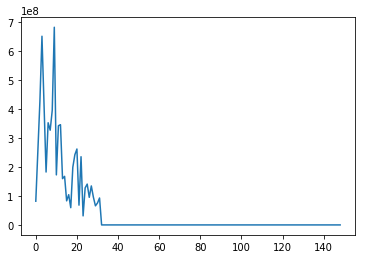

In [154]:
idx = 811
print(labels[idx])
pyplot.plot(X[idx,:])

In [173]:
skf = StratifiedKFold(n_splits=5)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index, :], X[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    clf = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=0)
    clf.fit(X_train, y_train)
    print(confusion_matrix(y_test, clf.predict(X_test)))
    print(clf.score(X_test, y_test))

[[87  0  0  3  5  0  0  4]
 [ 0 31  0  2  0  0  0  1]
 [ 1  2  5  6  0  0  0  1]
 [ 1  0  0 73  0  0  0  8]
 [ 5  0  0  0 70  0  0  2]
 [ 1  0  0  0  0 27  0  1]
 [ 1  0  0  0  1  0  9  2]
 [ 1  0  0  3  0  1  0 83]]
0.8810068649885584
[[87  1  0  7  2  0  0  2]
 [ 0 32  0  1  0  0  0  1]
 [ 1  0 10  3  0  1  0  0]
 [ 1  6  0 73  0  0  0  2]
 [ 2  0  0  0 74  0  0  0]
 [ 0  1  0  0  1 21  0  6]
 [ 0  0  0  0  1  1 10  1]
 [ 4  2  0  7  1  0  0 73]]
0.8735632183908046
[[95  0  0  3  0  0  0  1]
 [ 0 29  0  5  0  0  0  0]
 [ 0  0  8  7  0  0  0  0]
 [ 1  0  1 77  0  0  0  3]
 [ 3  0  0  0 73  0  0  0]
 [ 1  0  0  1  0 19  0  8]
 [ 0  0  0  0  2  0  9  1]
 [ 0  0  0  2  2  0  0 83]]
0.9055299539170507
[[93  0  0  0  3  0  0  2]
 [ 0 33  0  1  0  0  0  0]
 [ 1  0  7  6  0  0  0  1]
 [ 4  1  0 70  0  0  0  7]
 [ 3  0  0  0 73  0  0  0]
 [ 0  0  0  0  0 23  0  5]
 [ 0  0  0  0  2  0  9  1]
 [ 4  0  0  6  0  0  1 76]]
0.8888888888888888
[[90  0  0  4  3  0  1  0]
 [ 0 28  0  1  0  2  0  2]
 [